In [1]:
import sys, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.signal
import importlib
import h5py
sys.path.append('/Users/ajc/Core/PyScript')
import readdata

In [18]:
path = "/Users/ajc/FUSE/simulations/synthetic_watershed/SIM_01/no_vis"
outfile ='/Users/ajc/Core/PostProcessing/synthetic_watershed/08_02_2021/July/'

colors = ['r','blue','grey','green','darkgreen','k']
marks = ['.','*', '+', 'o']
#marks = ['-','-','-','-','-']

SimLabels = ['S%s'%i for i in range(0,2,1)]

In [19]:
S0 = [os.path.join(path, 'DM_I40_P80_S0_A0_N4/')]
S1 = [os.path.join(path, 'DM_I40_P80_S0_A1_N4/')]
S3 = [os.path.join(path, 'DM_I40_P80_S3_A1_N4/')]
S6 = [os.path.join(path, 'DM_I40_P80_S6_A1_N4/')]

Simulations = [S0, S1]
#Simulations = [S1, S3, S6]
Labels = ['flat','3%','6%']
Simulations
sim_len = len(Simulations)

In [20]:
def get_vars_names(simul):
    names = dict()
    #file = os.path.join(Simulations[0][0],'data_collection.dat')
    file = os.path.join(simul,'data_collection.dat')
    with open(file) as fd:
        count = 0
        for f in fd:
            if ('Observation Name' in f):
                f1 = f.split(':')
                #print (f1, f[-1])
                if 'time [d]' in f1[-1]:
                    names['Time'] = count
                    #print (f1, f1[-1],names)
                elif 'outlet discharge [mol d^-1]' in f1[-1]:
                    names['Discharge'] = count 
                elif 'total evaporation [m d^-1]' in f1[-1]:
                    names['ET'] = count
                elif 'snow precipitation [m d^-1]' in f1[-1]:
                    names['Psnow'] = count
                elif 'rain precipitation [m d^-1]' in f1[-1]:
                    names['Prain'] = count
                elif 'subsurface water content [mol]' in f1[-1]:
                    names['SS_wc'] = count
                    #print (count)
                elif 'surface water content [mol]' in f1[-1]:
                    #print (count)
                    names['Sf_wc'] = count
                elif 'snow water content [mol]' in f1[-1]: #but this is in m^3 correction
                    names['Snow_wc'] = count
                elif 'surface air temperature [K]' in f1[-1]:
                    names['Tair'] = count
                elif 'surface carbon decomposition rate [-]' in f1[-1]:
                    names['Sf_CDR'] = count
                elif 'surface moisture content [-]' in f1[-1]:
                    names['Sf_mc'] = count
                elif 'surface gas content [-]' in f1[-1]:
                    names['Sf_gc'] = count
                elif 'surface volumetric wc [-]' in f1[-1]:
                    names['Sf_vol_wc'] = count
                elif 'surface gas content [-]' in f1[-1]:
                    names['Sf_gc'] = count
                elif 'surface column average temperature [K]' in f1[-1]:
                    names['Sf_avg_T'] = count
                elif 'surface ALT average temperature [K]' in f1[-1]:
                    names['Sf_ALT_avg_T'] = count
                elif 'surface saturated_fraction [-]' in f1[-1]:
                    names['Sf_sat_frac'] = count
                elif 'surface thaw depth min [m]' in f1[-1]:
                    names['Sf_TD_min'] = count
                elif 'surface thaw depth max [m]' in f1[-1]:
                    names['Sf_TD_max'] = count
                elif 'surface maximum thaw depth [m]' in f1[-1]:
                    names['Sf_maxTD'] = count
                elif 'surface water table [m]' in f1[-1]:
                    names['Sf_WT'] = count
                elif 'surface subsurface exchange [m]' in f1[-1]:
                    names['Sf_exchangeFlux'] = count
                elif 'surface initial elevation [m]' in f1[-1]:
                    names['Sf_InitElev'] = count
                elif 'surface mean subsidence [m]' in f1[-1]:
                    names['Sf_mean_Subsidence'] = count
                else:
                    #names['Sf_DNE_%s'%count] = count
                    print ('DNE:',count, f[-1])
                count = count + 1
    return names

In [21]:

def get_daily_data():
    daily = dict()
    for i,sim in enumerate(Simulations):
        df = pd.DataFrame(columns=[''])
        
        for s in sim:
            file = os.path.join(s,'data_collection.dat')
            
            df1 = pd.read_csv(file, comment='#')
            names = get_vars_names(s)
            print (file, len(names.keys()))
            df1.columns = names.keys()
            
            rows,cols = df1.shape
            rows = rows - rows%365.
            df1 = df1.truncate(before=0,after=rows-1,axis='index')
            
            df = df.append(df1)
            #print (df)
        daily[SimLabels[i]] = df
        
    return daily

SimData_daily = get_daily_data()

/Users/ajc/FUSE/simulations/synthetic_watershed/SIM_01/no_vis/DM_I40_P80_S0_A0_N4/data_collection.dat 23
/Users/ajc/FUSE/simulations/synthetic_watershed/SIM_01/no_vis/DM_I40_P80_S0_A1_N4/data_collection.dat 23


In [22]:
to_year = 365
to_mm = 1000
molar_density = 55500.
surface_area = 1000 * 1000
def get_discharge():
    Q_daily = dict()
    Q_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    print (SimData_daily.keys(),keys)
    for i in range(size):
        convert = 1/(molar_density*surface_area)
        d = [x* convert for x in SimData_daily[keys[i]]['Discharge'] ]
        Q_daily[keys[i]]= d*to_mm
        #print (d.shape)
        Q_annual[keys[i]]= np.reshape(d,(-1,365)).mean(axis=1)*to_year * to_mm
    return Q_daily, Q_annual
Q_daily, Q_annual = get_discharge()

def get_time():
    T_daily = dict()
    T_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    print (SimData_daily.keys(),keys)
    for i in range(size):
        convert = 1./(365)
        d = [1985 + x* convert for x in SimData_daily[keys[i]]['Time'] ]
        T_daily[keys[i]]= d
        T_annual[keys[i]]= np.reshape(d,(-1,365)).mean(axis=1)
    return T_daily, T_annual
T_daily, T_annual = get_time()

dict_keys(['S0', 'S1']) ['S0', 'S1']
dict_keys(['S0', 'S1']) ['S0', 'S1']


In [23]:
def get_ET():
    ET_daily = dict()
    ET_annual = dict()
    size = len(SimData_daily.keys())
    keys = list(SimData_daily.keys())
    #print (SimData_daily.keys(),keys)
    for i in range(size):
        convert = 1
        d = [x* convert for x in SimData_daily[keys[i]]['ET'] ]
        ET_daily[keys[i]]= d*to_mm
        ET_annual[keys[i]]= np.reshape(d,(-1,365)).mean(axis=1)*to_year * to_mm
    return ET_daily, ET_annual
ET_daily, ET_annual = get_ET()

In [24]:
ET_annual

{'S0': array([156.30148421, 181.20014011, 178.1777012 , 187.13425307,
        328.88514921, 144.06613943, 126.54995143, 141.72302932,
        225.15109525, 170.68309481, 145.11341914,  99.3308225 ,
        159.35582956, 166.21637384, 183.40495743, 208.40168478,
        210.87319516, 205.46591786, 168.40192492, 293.64418029,
        203.75504882, 232.77992992, 169.17209467, 223.45573194,
        264.32002725, 252.00717798, 336.32056353, 281.76344891,
        360.49205909, 293.35879888, 273.7073861 ]),
 'S1': array([157.07509991, 180.51774189, 176.11010575, 188.19854649,
        335.1666155 , 144.99150685, 126.64028759, 141.94455008,
        224.22199259, 170.55130636, 145.1087207 ,  99.04918583,
        158.08124066, 166.0694369 , 182.2009518 , 208.23287124,
        210.70613376, 205.52784959, 167.11215057, 293.81174654,
        206.46833907, 230.95543426, 168.25926948, 224.52541876,
        265.54237786, 248.24943684, 338.90273786, 281.44328933,
        359.6639986 , 293.1877931 , 272.

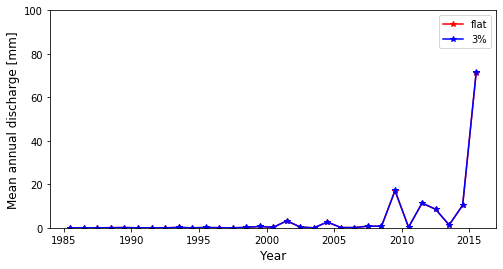

In [25]:
bars = False #True
fig = plt.figure(figsize=(8,4))
x = np.arange(0,4,1)
Colors = ['r', 'g', 'b','grey']

if not bars:
    for i in range(sim_len):
        s = SimLabels[i]
        #d = get_moving_average(Q_annual[s],m=1)
        d = Q_annual[s]
        plt.plot(T_annual[s][:32],d[:32],label=Labels[i],color=colors[i],marker='*')
        plt.legend()
        plt.ylabel('Mean annual discharge [mm]',fontsize=12, fontweight='normal')
        plt.xlabel('Year',fontsize=12, fontweight='normal')
        plt.ylim(0,100)
        #plt.xlim(2005.5,2099.5)
    #for y in cesm_years_o:
    #    plt.axvline(x=y)
        
        #plt.savefig(outfile+'/Projected-Q_linesA.pdf', bbox_inches='tight', dpi=500)
        #plt.savefig(outfile+'/Projected-Q_por_sensivity_por.pdf', bbox_inches='tight', dpi=500)
else:
    dat = []
    for i in [2,0,1]:
        s = SimLabels[i]
        d = []
        
        for k1,k in enumerate(cesm_years):
            print (s, k, Q_annual[s][k], len(Q_annual[s]))
            d.append(Q_annual[s][k])
        print (d,cesm_years)
        print ('--------_')
        #d = [c/Q_annual[SimLabels[2]][0] for c in d]
        dat.append(d)
        plt.bar(x, height=d, width=0.2,color=Colors[i],alpha=1,label=Labels[i])
   
    #d1 = [dat[0][k4] - dat[1][k4] for k4 in range(4)]
    #plt.bar(x+0.21, height=d1, width=0.2,color=Colors[3],alpha=1)#,label=Labels[i])
    plt.legend()
    plt.ylabel('Mean annual discharge [mm]',fontsize=12, fontweight='normal')
    plt.xlabel('Year',fontsize=12, fontweight='normal')
    plt.xticks(x, cesm_years_o)
    plt.savefig(outfile+'/Projected-Q_lines.pdf', bbox_inches='tight', dpi=500)





Text(0.5, 0, 'Year')

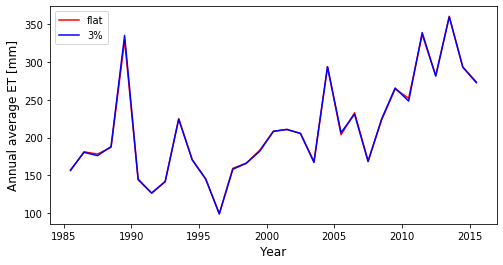

In [27]:
fig = plt.figure(figsize=(8,4))
for i,s in enumerate(SimLabels):
    d = ET_annual[s] #get_moving_average(ET_annual[s])
    plt.plot(T_annual[s],d,label=Labels[i],color=colors[i])
plt.legend()
plt.ylabel('Annual average ET [mm]',fontsize=12, fontweight='normal')
plt.xlabel('Year',fontsize=12, fontweight='normal')
#plt.ylim(100,400)
#plt.xlim(2006.5,2099.5)
#plt.savefig(outfile+'/Projected-ET.pdf', bbox_inches='tight', dpi=500)
#plt.savefig(outfile+'/Projected-ET_sensivity_por.pdf', bbox_inches='tight', dpi=500)